# TEL354 - Minería de Datos

# Taller 3: Exploración Semántica y Emocional de Cuentos

**Objetivo general:** Aplicar técnicas de procesamiento de lenguaje natural a textos narrativos, extrayendo características léxicas, semánticas, sintácticas y emocionales, con visualizaciones interpretativas y una reflexión final sobre los patrones encontrados.

Nombre: Nelson Sepúlveda 202004610-7

In [137]:
# Consolidado de librerías
import re
import pandas as pd
import spacy
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS as sklearn_stopwords
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation

# Parte 1: Selección y Carga de los Cuentos

- Selecciona al menos 3 cuentos clásicos en español de autores diferentes (ej. Horacio Quiroga, Rubén Darío, Emilia Pardo Bazán, Gabriela Mistral, Baldomero Lillo, etc.).

- Los textos deben estar en formato .txt. Puedes obtenerlos desde:

    - [Proyecto Gutenberg](https://www.gutenberg.org/)

    - [Wikisource](https://es.wikisource.org/)
    
- Limpia el encabezado y pie del texto (metadatos editoriales).

- Carga los cuentos en un `DataFrame`, con una fila por párrafo (o por oración), indicando:

    - Título

    - Autor

    - Número de párrafo

    - Texto

In [138]:
def procesar_libro_por_rango(ruta_archivo, titulo, autor, inicio_texto, fin_texto):
    """
    ruta_archivo:   Ruta al archivo de texto (.txt).
    titulo:         Cadena con el título de la obra para la columna “Título” del DataFrame.
    autor:          Cadena con el nombre del autor para la columna “Autor” del DataFrame.
    inicio_texto:   Cadena con el inicio de la obra que señala dónde comienza la sección a extraer.
    fin_texto:      Cadena con el final de la obra que señala dónde termina la sección a extraer.

    descripción:    Extrae el texto de un libro desde un archivo de texto, delimitado por cadenas de inicio y fin.
    """
    with open(ruta_archivo, 'r', encoding='utf-8') as f:
        lineas = f.readlines()

    dentro_del_texto = False
    contenido_crudo = []

    for linea in lineas:
        linea_strip = linea.rstrip('\n')
        if not dentro_del_texto and inicio_texto.lower() in linea_strip.lower():
            dentro_del_texto = True
            contenido_crudo.append(linea_strip)
            continue
        elif dentro_del_texto:
            contenido_crudo.append(linea_strip)
            if fin_texto.lower() in linea_strip.lower():
                break

    parrafos = []
    parrafo_actual = []
    for linea in contenido_crudo:

        if linea.strip() == "":

            if parrafo_actual:
                texto_parrafo = " ".join(parrafo_actual).strip()
                parrafos.append(texto_parrafo)
                parrafo_actual = []

        else:

            parrafo_actual.append(linea.strip())

    if parrafo_actual:
        texto_parrafo = " ".join(parrafo_actual).strip()
        parrafos.append(texto_parrafo)

    df = pd.DataFrame({
        "Título": [titulo] * len(parrafos),
        "Autor": [autor] * len(parrafos),
        "Número de párrafo": list(range(1, len(parrafos) + 1)),
        "Texto": parrafos
    })

    return df

In [165]:
ruta_archivo_1 = "Cuentos de Amor de Locura y de Muerte.txt"

df1 = procesar_libro_por_rango(
    ruta_archivo_1,
    "Cuentos de Amor de Locura y de Muerte",
    "Horacio Quiroga",
    "#Primavera#",
    "¿Qué más puedo añadir?"
)

df1.head()

Título            Autor  Número de párrafo  \
0  Cuentos de Amor de Locura y de Muerte  Horacio Quiroga                  1   
1  Cuentos de Amor de Locura y de Muerte  Horacio Quiroga                  2   
2  Cuentos de Amor de Locura y de Muerte  Horacio Quiroga                  3   
3  Cuentos de Amor de Locura y de Muerte  Horacio Quiroga                  4   
4  Cuentos de Amor de Locura y de Muerte  Horacio Quiroga                  5   

                                               Texto  
0                                        #Primavera#  
1  Era el martes de carnaval. Nébel acababa de en...  
2                        --¿Quién es? No parece fea.  
3  --¡Un demonio! Es lindísima. Creo que sobrina,...  
4  Nébel fijó entonces atentamente los ojos en la...

In [166]:
ruta_archivo_2 = "Cuentos de amor.txt"

df2 = procesar_libro_por_rango(
    ruta_archivo_2,
    "Cuentos de amor",
    "Emilia Pardo Bazán",
    "El amor asesinado",
    "temblar una lágrima."
)

df2.head()

Título               Autor  Número de párrafo  \
0  Cuentos de amor  Emilia Pardo Bazán                  1   
1  Cuentos de amor  Emilia Pardo Bazán                  2   
2  Cuentos de amor  Emilia Pardo Bazán                  3   
3  Cuentos de amor  Emilia Pardo Bazán                  4   
4  Cuentos de amor  Emilia Pardo Bazán                  5   

                                               Texto  
0                                  El amor asesinado  
1  Nunca podrá decirse que la infeliz Eva omitió ...  
2  Empezó poniendo tierra en medio, viajando para...  
3  Entonces Eva, que no se dormía, mandó construi...  
4  Furiosa, hizo tomar las grietas y calafatear l...

In [167]:
ruta_archivo_3 = "La Quimera.txt"

df3 = procesar_libro_por_rango(
    ruta_archivo_3,
    "La Quimera",
    "Emilia Pardo Bazán",
    "ACTO PRIMERO",
    "SINFONÍA, tal vez más sentida que las anteriores."
)

df3.head()

Título               Autor  Número de párrafo  \
0  La Quimera  Emilia Pardo Bazán                  1   
1  La Quimera  Emilia Pardo Bazán                  2   
2  La Quimera  Emilia Pardo Bazán                  3   
3  La Quimera  Emilia Pardo Bazán                  4   
4  La Quimera  Emilia Pardo Bazán                  5   

                                               Texto  
0                                       ACTO PRIMERO  
1  El teatro representa una sala baja del palacio...  
2                                     ESCENA PRIMERA  
3                               CASANDRA, EL RAPSODA  
4  _Casandra._--Bienvenido. Á ver si con tus canc...

# Parte 2: Preprocesamiento Avanzado del Texto

- Realiza limpieza y normalización: Minúsculas, eliminación de signos y números, etc.

- Tokeniza por oraciones y por palabras.

- Elimina stopwords en español.

- Aplica lema o raíz (lematización con `spaCy`).

- Extrae características básicas:

    - Largo promedio de oraciones.

    - Frecuencia de palabras por cuento.

    - Frecuencia de verbos, sustantivos y adjetivos.
    
- Genera una tabla comparativa por cuento con estadísticas básicas como la siguiente:

| Título                      | Palabras totales | Prom. palabras/oración | % verbos | % adjetivos |
|----------------------------|------------------|-------------------------|----------|--------------|
| El almohadón de plumas     | 1324             | 12.4                    | 27%      | 14%          |
| El velo de la reina Mab    | 1982             | 14.3                    | 23%      | 18%          |

In [142]:
nlp = spacy.load("es_core_news_sm")
nlp.max_length = 2_000_000

stopwords = nlp.Defaults.stop_words

In [143]:
def preprocesar_y_extraer_stats(df_cuento, titulo):

    texto = "\n".join(df_cuento["Texto"].tolist()).lower()

    texto = re.sub(r"[^a-záéíóúñü\s\.\!\?]", " ", texto)

    doc = nlp(texto)

    total_oraciones = 0
    total_palabras = 0
    verbos = adjetivos = sustantivos = 0

    for sent in doc.sents:
        total_oraciones += 1
        tokens_validos = [
            tok for tok in sent
            if tok.is_alpha
            and tok.lemma_ not in stopwords
            and len(tok.lemma_) >= 2
        ]
        total_palabras += len(tokens_validos)
        for tok in tokens_validos:
            if tok.pos_ == "VERB":   verbos += 1
            elif tok.pos_ == "ADJ":  adjetivos += 1
            elif tok.pos_ == "NOUN": sustantivos += 1

    pct = lambda cnt: round(cnt / total_palabras * 100, 1) if total_palabras else 0.0
    df_stats = pd.DataFrame([{
        "Título": titulo,
        "Palabras totales": total_palabras,
        "Prom. palabras/oración": round(total_palabras / total_oraciones, 1) if total_oraciones else 0.0,
        "% verbos": f"{pct(verbos)}%",
        "% adjetivos": f"{pct(adjetivos)}%",
        "% sustantivos": f"{pct(sustantivos)}%"
    }])
    return df_stats

In [144]:
stats_1 = preprocesar_y_extraer_stats(df1, "Cuentos de Amor de Locura y de Muerte")
stats_2 = preprocesar_y_extraer_stats(df2, "Cuentos de amor")
stats_3 = preprocesar_y_extraer_stats(df3, "La Quimera")

resumen = pd.concat([stats_1, stats_2, stats_3], ignore_index=True)

columnas_orden = [
    "Título",
    "Palabras totales",
    "Prom. palabras/oración",
    "% verbos",
    "% adjetivos",
    "% sustantivos"
]

resumen = resumen[columnas_orden]
resumen

Título  Palabras totales  \
0  Cuentos de Amor de Locura y de Muerte             20610   
1                        Cuentos de amor             26868   
2                             La Quimera             57042   

   Prom. palabras/oración % verbos % adjetivos % sustantivos  
0                     7.4    28.3%       16.0%         47.8%  
1                    14.6    28.9%       17.4%         48.0%  
2                     9.4    26.8%       18.6%         48.9%

# Parte 3: Análisis de Sentimiento y Emociones

- Para cada párrafo u oración, realiza análisis emocional usando un modelo preentrenado como [`beto`](https://huggingface.co/finiteautomata/beto-sentiment-analysis) o [`nlptown`](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment).

- Extrae emociones dominantes por párrafo/oración (alegría, tristeza, miedo, ira, sorpresa, etc.).

- Calcula el perfil emocional de cada cuento (frecuencia relativa de cada emoción).

- Visualiza la evolución emocional del cuento a lo largo de los párrafos como línea temporal.

- Genera un gráfico de tipo línea:
    - Eje X: párrafos (o tiempo).
    - Eje Y: puntaje de emoción (ej. miedo, tristeza, alegría).

- Genera una tabla resumen con perfil emocional por cuento.

In [145]:
checkpoint = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True, device=-1)

Device set to use cpu
c:\Users\nelso\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [146]:
def analyze_sentiment(df, title):
    """
    df:         DataFrame de los cuentos.
    title:      Cadena con el título del cuento.

    Descripción: Analiza el sentimiento de los párrafos de un cuento utilizando un modelo preentrenado de clasificación de texto.
    """
    rows = []

    for _, r in df.iterrows():
        text = r["Texto"]
        num = r["Número de párrafo"]
        scores = pipe(text, truncation=True)[0]
        probas = {item["label"]: item["score"] for item in scores}
        dominant = max(probas, key=lambda k: probas[k])
        rec = {"Título": title, "Número de párrafo": num, "Texto": text, "Rating dominante": dominant}

        for label, val in probas.items():
            rec["P_" + label.replace(" ", "")] = val

        rows.append(rec)

    df_sent = pd.DataFrame(rows)
    profile_abs = df_sent["Rating dominante"].value_counts().to_dict()
    profile_rel = {k: round(v / sum(profile_abs.values()) * 100, 1) for k, v in profile_abs.items()}
    
    return df_sent, profile_rel

In [147]:
df1s, prof1 = analyze_sentiment(df1, "Cuentos de Amor de Locura y de Muerte")
df2s, prof2 = analyze_sentiment(df2, "Cuentos de amor")
df3s, prof3 = analyze_sentiment(df3, "La Quimera")

df_perfil = pd.DataFrame([prof1, prof2, prof3], index=[
    "Cuentos de Amor de Locura y de Muerte",
    "Cuentos de amor",
    "La Quimera"
]).fillna(0)

df_perfil = df_perfil[["1 star", "2 stars", "3 stars", "4 stars", "5 stars"]]

df_perfil

1 star  2 stars  3 stars  4 stars  \
Cuentos de Amor de Locura y de Muerte    51.3     20.9      7.0      4.0   
Cuentos de amor                          45.2     20.8      4.2      6.3   
La Quimera                               49.8     16.3      5.5      4.0   

                                       5 stars  
Cuentos de Amor de Locura y de Muerte     16.8  
Cuentos de amor                           23.5  
La Quimera                                24.4

In [148]:
def plot_evolution(df_sent, title):
    """
    df_sent: DataFrame con columnas "Número de párrafo" y variables que empiecen con "P_"
    title:   Cadena que se usa como título del gráfico

    Descripción: Grafica la evolución de las probabilidades (columnas P_*) a lo largo de los párrafos, ocupando todo el ancho de la figura en el eje X.
    """
    df_ord = df_sent.sort_values("Número de párrafo").reset_index(drop=True)
    x = df_ord["Número de párrafo"]

    cols = [c for c in df_ord.columns if c.startswith("P_")]

    fig, ax = plt.subplots(figsize=(20, 4))

    for c in cols:
        ax.plot(
            x,
            df_ord[c],
            marker="o",
            markersize=2,
            linewidth=1,
            label=c.replace("P_", "")
        )

    ax.set_xlim(x.min(), x.max())
    ax.margins(x=0)

    ax.set_title(title)
    ax.set_xlabel("Número de párrafo")
    ax.set_ylabel("Probabilidad")

    ax.legend(loc="upper right", bbox_to_anchor=(1.02, 1), fontsize="small")

    plt.tight_layout()
    plt.show()


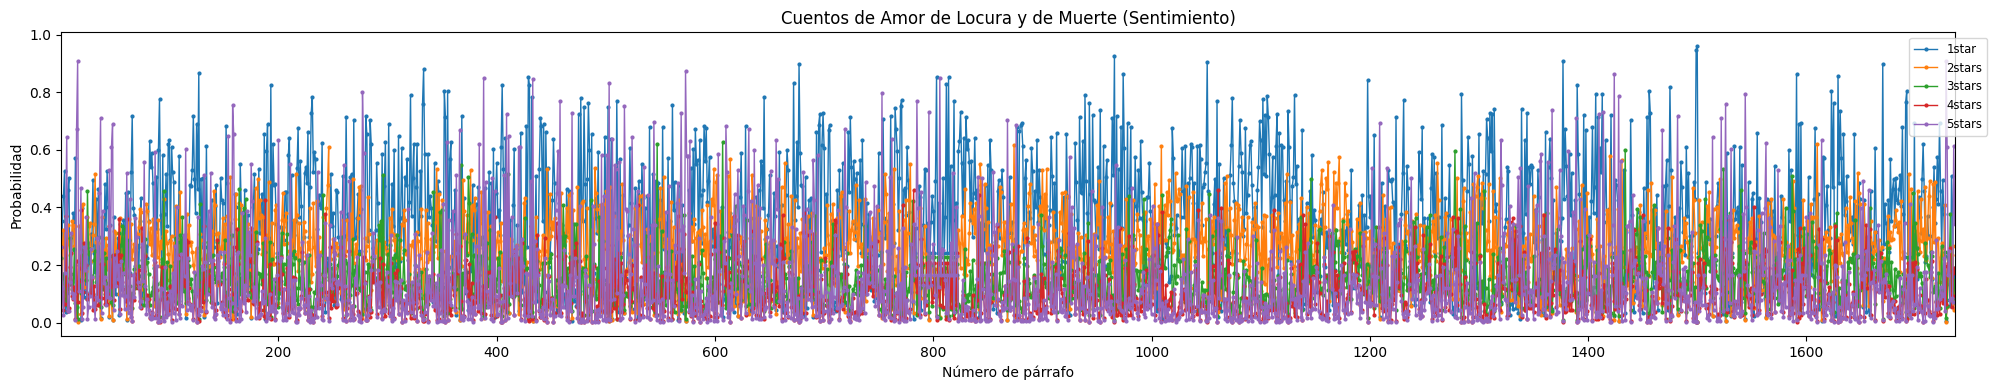

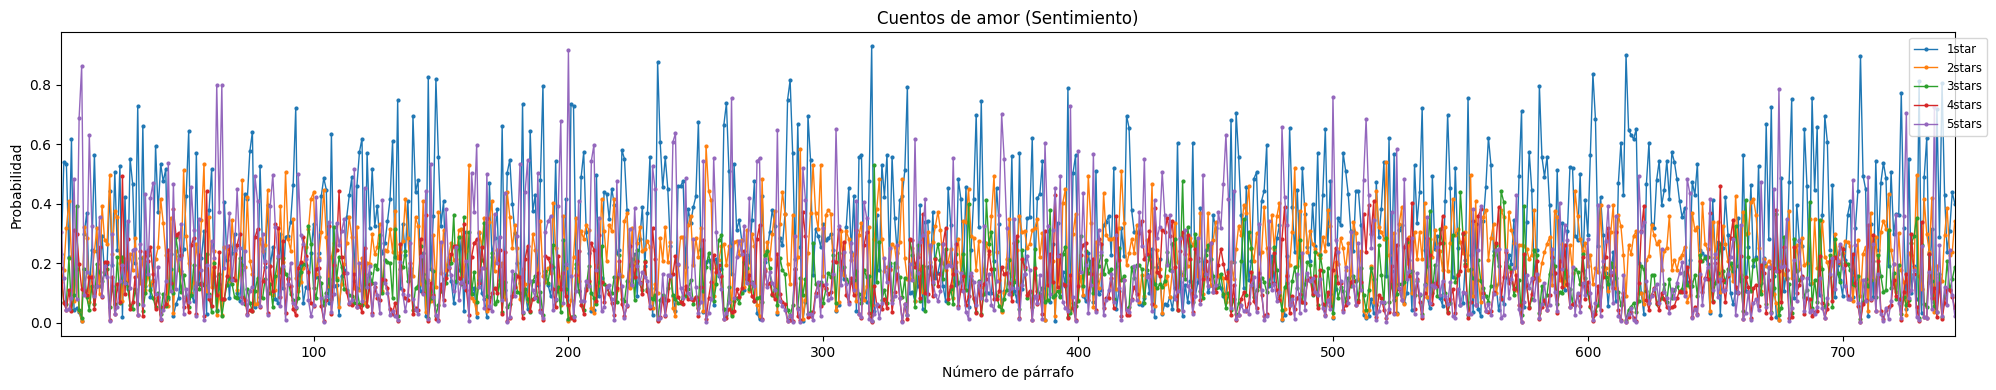

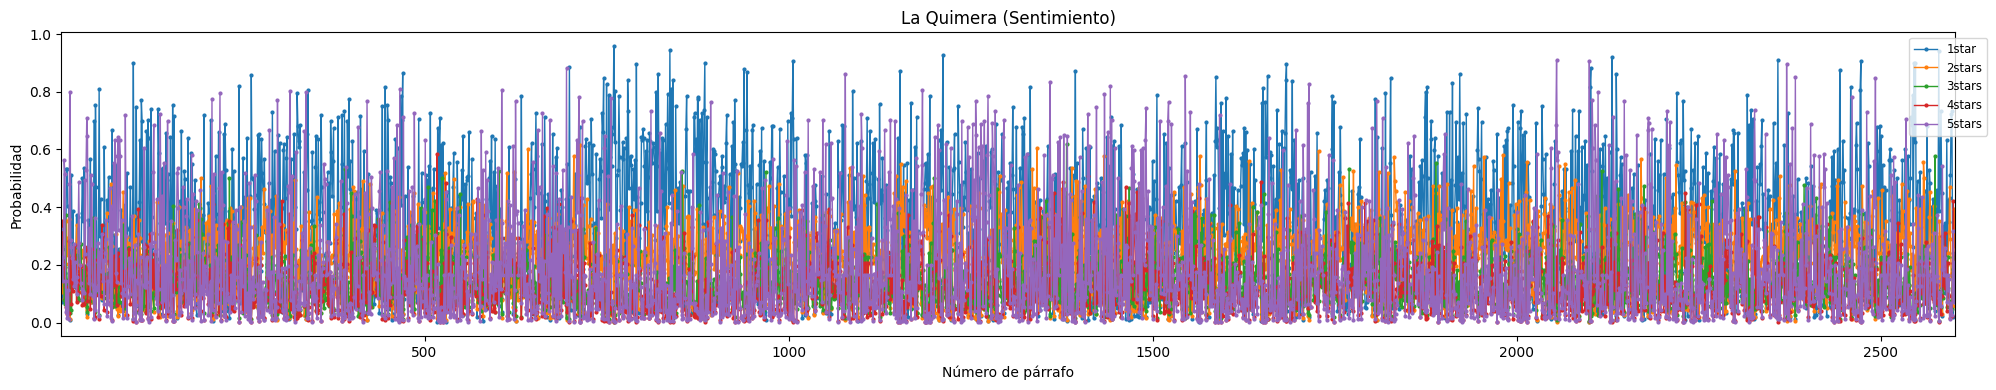

In [149]:
plot_evolution(df1s, "Cuentos de Amor de Locura y de Muerte (Sentimiento)")
plot_evolution(df2s, "Cuentos de amor (Sentimiento)")
plot_evolution(df3s, "La Quimera (Sentimiento)")

# Parte 4: Análisis Semántico y Tópico

- Genera una matriz de términos TF-IDF por cuento.

- Aplica clustering de oraciones o párrafos para encontrar secciones temáticas.

- Aplica LDA (Latent Dirichlet Allocation) para detectar temas recurrentes.

- Visualizar los tópicos en cada cuento:

    - nubes de palabras por tópico.
    - gráfico de barras por peso del tema.

In [150]:
def limpiar_parrafo(texto):
    texto = texto.lower()
    texto = re.sub(r"[^a-záéíóúñü\s]", " ", texto)
    tokens = texto.split()
    stop_es = {
        "que","de","la","el","y","a","los","del","se","las","por","un","para","con","no","una","su","al",
        "lo","como","más","pero","sus","le","ya","o","este","sí","porque","esta","entre","cuando","muy",
        "sin","sobre","también","me","hasta","hay","donde","quien","desde","todo","nos","durante","todos",
        "uno","les","ni","contra","otros","ese","eso","ante","ellos","e","esto","mí","antes","algunos","qué",
        "unos","yo","otro","otras","otra","él","tanto","esa","estos","mucho","quienes","nada","muchos","cual",
        "poco","ella","estar","estas","algunas","algo","nosotros","mi","mis","tú","te","ti","tu","tus","ellas",
        "nosotras","vosotros","vosotras","os","mío","mía","míos","mías","tuyo","tuya","tuyos","tuyas","suyo",
        "suya","suyos","suyas"
    }
    resultado = []
    for tok in tokens:
        if len(tok) < 2: continue
        if tok in stop_es: continue
        if tok in sklearn_stopwords: continue
        resultado.append(tok)
    return resultado

df1["Tokens"] = df1["Texto"].apply(limpiar_parrafo)
df2["Tokens"] = df2["Texto"].apply(limpiar_parrafo)
df3["Tokens"] = df3["Texto"].apply(limpiar_parrafo)

In [151]:
def construir_tfidf(df):
    docs = [" ".join(toks) for toks in df["Tokens"]]
    vec = TfidfVectorizer(max_df=0.9, min_df=2)
    X = vec.fit_transform(docs)
    return X, vec.get_feature_names_out()

tfidf1, vocab1 = construir_tfidf(df1)
tfidf2, vocab2 = construir_tfidf(df2)
tfidf3, vocab3 = construir_tfidf(df3)

In [152]:
def asignar_clusters(X, n_clusters=4):
    km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    return km.fit_predict(X)

df1["Cluster"] = asignar_clusters(tfidf1)
df2["Cluster"] = asignar_clusters(tfidf2)
df3["Cluster"] = asignar_clusters(tfidf3)

In [153]:
def top_terms_cluster(X, vocab, labels, top_n=10):
    tops = {}
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        sub = X[idx].mean(axis=0).A1
        top_idxs = sub.argsort()[::-1][:top_n]
        tops[c] = [vocab[i] for i in top_idxs]
    return tops

print("Cuento 1 clusters:", top_terms_cluster(tfidf1, vocab1, df1["Cluster"]))
print("Cuento 2 clusters:", top_terms_cluster(tfidf2, vocab2, df2["Cluster"]))
print("Cuento 3 clusters:", top_terms_cluster(tfidf3, vocab3, df3["Cluster"]))

Cuento 1 clusters: {np.int32(0): ['dijo', 'nébel', 'dije', 'ojos', 'si', 'después', 'vez', 'mamá', 'va', 'murmuró'], np.int32(1): ['en', 'había', 'dos', 'era', 'día', 'ojos', 'nébel', 'fin', 'vez', 'tres'], np.int32(2): ['es', 'usted', 'cierto', 'si', 'decir', 'dicho', 'vez', 'dijo', 'quién', 'en'], np.int32(3): ['maría', 'está', 'elvira', 'luis', 'en', 'ojos', 'bien', 'funes', 'aquí', 'vez']}
Cuento 2 clusters: {np.int32(0): ['es', 'mujer', 'ángel', 'si', 'afra', 'ver', 'quiero', 'así', 'señor', 'ha'], np.int32(1): ['en', 'tan', 'había', 'don', 'si', 'casa', 'era', 'mismo', 'juan', 'vida'], np.int32(2): ['en', 'era', 'si', 'había', 'tan', 'ojos', 'es', 'así', 'dos', 'estaba'], np.int32(3): ['usted', 'es', 'mercedes', 'sor', 'en', 'aparición', 'si', 'romana', 'nadie', 'vamos']}
Cuento 3 clusters: {np.int32(0): ['en', 'es', 'silvio', 'era', 'había', 'si', 'tan', 'espina', 'vez', 'ha'], np.int32(1): ['es', 'silvio', 'si', 'clara', 'minia', 'ha', 'está', 'aquí', 'en', 'espina'], np.int32(

In [154]:
def entrenar_lda(X, num_topics=5, max_iter=10):
    lda = LatentDirichletAllocation(
        n_components=num_topics,
        max_iter=max_iter,
        random_state=42,
        learning_method="batch"
    )
    lda.fit(X)
    return lda

lda1 = entrenar_lda(tfidf1)
lda2 = entrenar_lda(tfidf2)
lda3 = entrenar_lda(tfidf3)

In [155]:
def mostrar_topicos_sklearn(lda, vocab, n=10):
    for i, comp in enumerate(lda.components_):
        terms = [vocab[idx] for idx in comp.argsort()[::-1][:n]]
        weights = comp[comp.argsort()[::-1][:n]]
        print(f"Tópico {i}: {terms}")

def wordcloud_topic(lda, vocab, topic_id):
    comp = lda.components_[topic_id]
    freqs = {vocab[i]: comp[i] for i in comp.argsort()[::-1][:50]}
    wc = WordCloud(width=400, height=300, background_color="white")
    wc.generate_from_frequencies(freqs)
    plt.figure(figsize=(6,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nube Topic {topic_id}")
    plt.show()

def bar_topic(lda, vocab, topic_id, n=10):
    comp = lda.components_[topic_id]
    idxs = comp.argsort()[::-1][:n]
    terms = [vocab[i] for i in idxs]
    weights = comp[idxs]
    plt.figure(figsize=(6,4))
    plt.barh(terms[::-1], weights[::-1], color="skyblue")
    plt.title(f"Tópico {topic_id} - Top {n}")
    plt.xlabel("Peso")
    plt.tight_layout()
    plt.show()

Tópico 0: ['en', 'dije', 'preguntó', 'es', 'oh', 'entonces', 'alfonso', 'perro', 'volvió', 'voz']
Tópico 1: ['en', 'murmuró', 'maría', 'vez', 'es', 'dijo', 'repuso', 'respondió', 'pasa', 'pasó']
Tópico 2: ['en', 'es', 'si', 'bien', 'ahora', 'había', 'nébel', 'va', 'era', 'lidia']
Tópico 3: ['en', 'había', 'marzo', 'después', 'mamá', 'estás', 'inés', 'día', 'casa', 'voz']
Tópico 4: ['ojos', 'creo', 'kassim', 'en', 'hombre', 'cayé', 'dijo', 'nébel', 'joven', 'levantó']


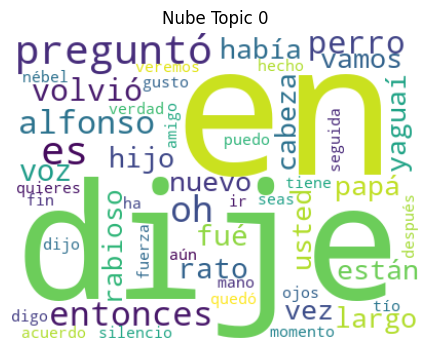

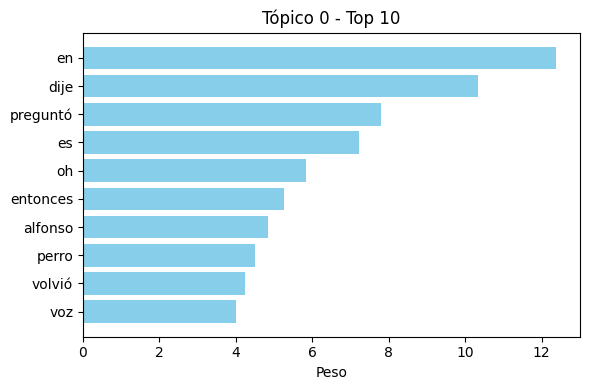

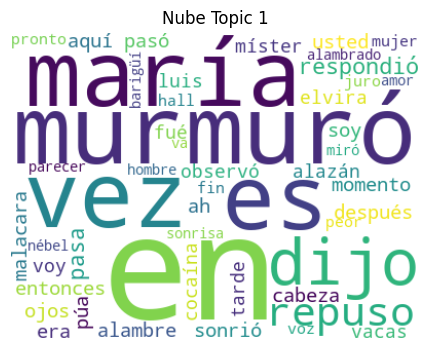

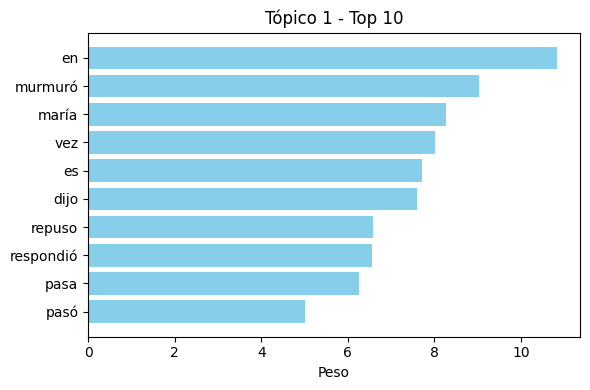

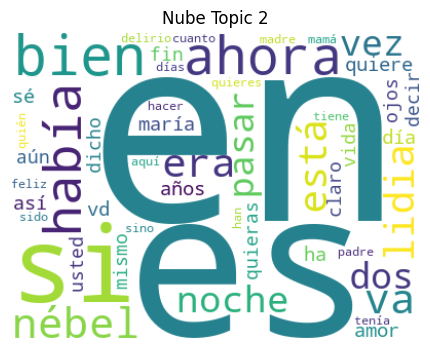

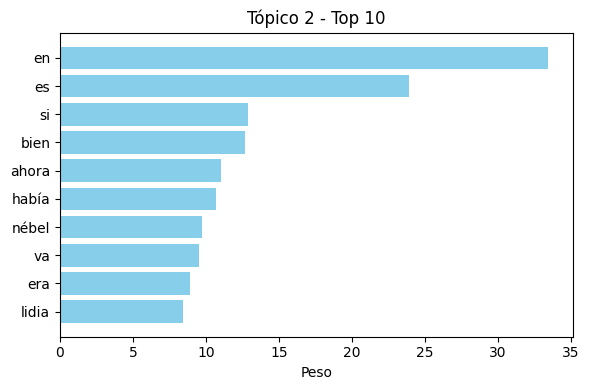

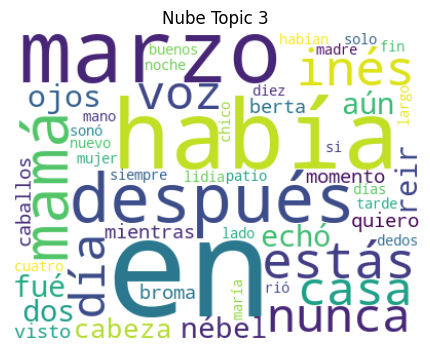

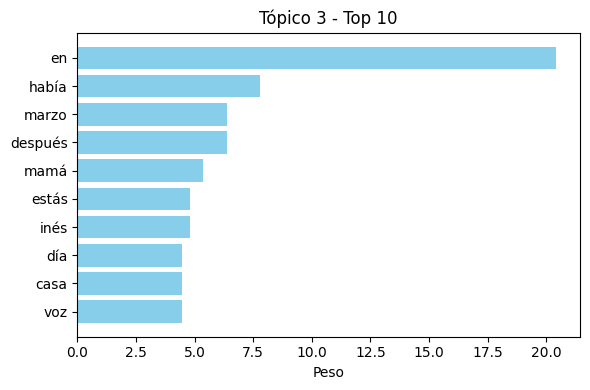

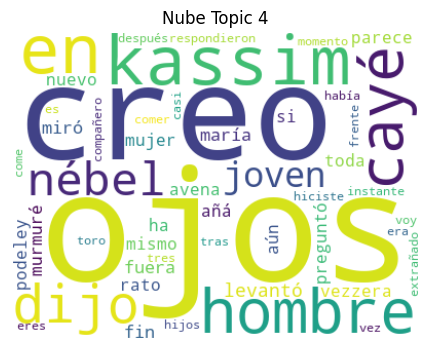

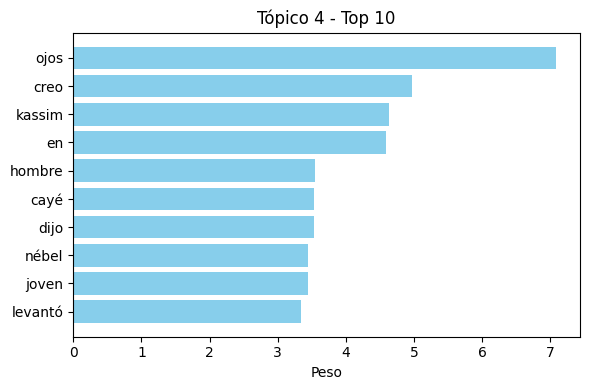

In [156]:
mostrar_topicos_sklearn(lda1, vocab1)
for t in range(5):
    wordcloud_topic(lda1, vocab1, t)
    bar_topic(lda1, vocab1, t)

Tópico 0: ['en', 'señor', 'si', 'amor', 'es', 'era', 'respondió', 'sólo', 'tan', 'ver']
Tópico 1: ['en', 'era', 'ángel', 'si', 'usted', 'es', 'había', 'pues', 'ojos', 'sólo']
Tópico 2: ['en', 'usted', 'es', 'martina', 'era', 'dos', 'tan', 'ojos', 'si', 'había']
Tópico 3: ['en', 'si', 'es', 'tan', 'había', 'usted', 'era', 'perla', 'fué', 'mujer']
Tópico 4: ['en', 'afra', 'tan', 'mujer', 'era', 'así', 'don', 'es', 'si', 'ver']


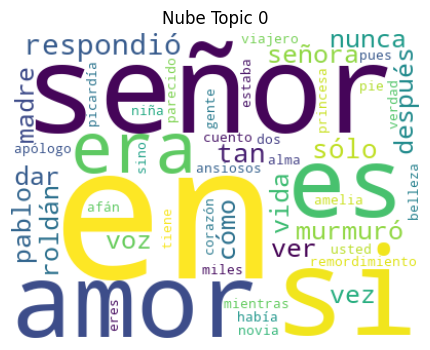

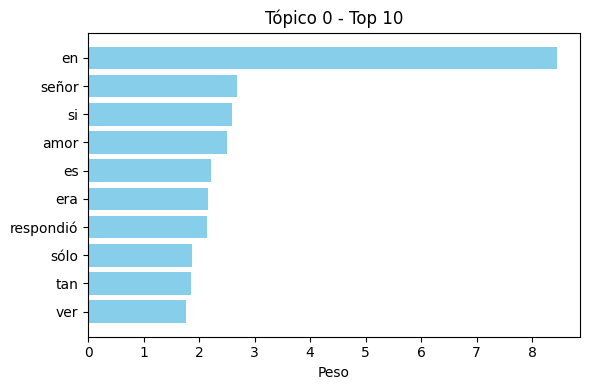

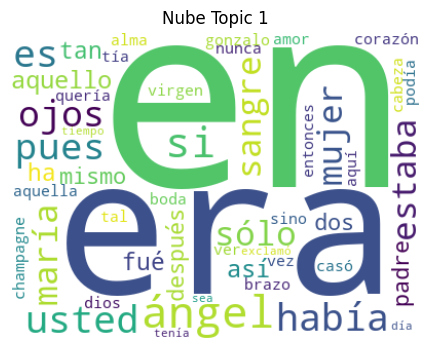

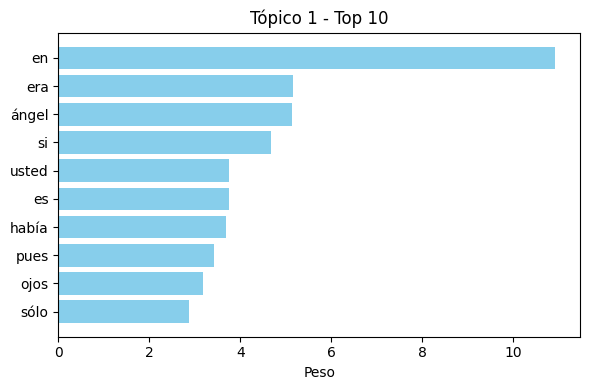

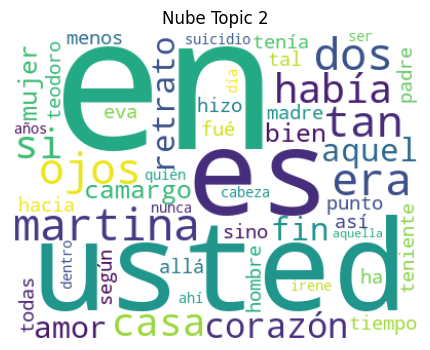

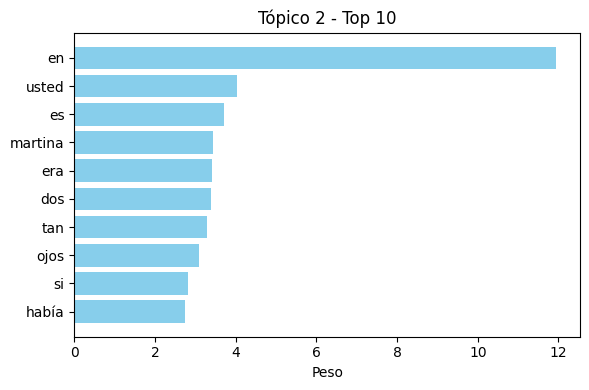

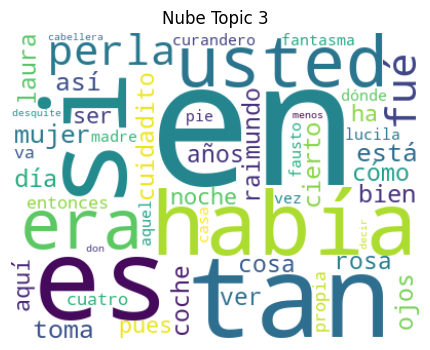

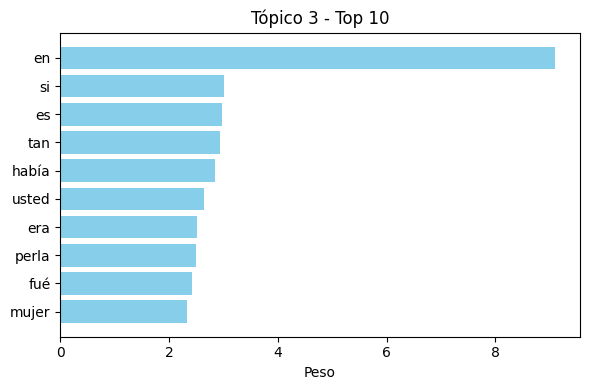

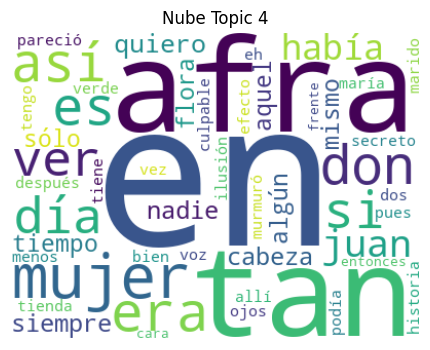

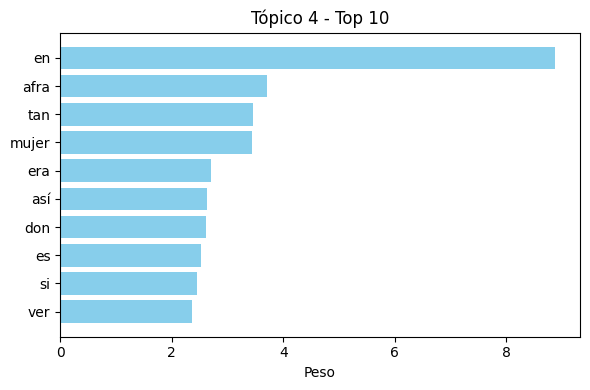

In [157]:
mostrar_topicos_sklearn(lda2, vocab2)
for t in range(lda2.n_components):
    wordcloud_topic(lda2, vocab2, t)
    bar_topic(lda2, vocab2, t)

Tópico 0: ['en', 'es', 'si', 'silvio', 'madrid', 'cómo', 'luz', 'tan', 'usted', 'ha']
Tópico 1: ['usted', 'en', 'es', 'si', 'silvio', 'minerva', 'ha', 'quimera', 'minia', 'belerofonte']
Tópico 2: ['en', 'usted', 'silvio', 'es', 'aquí', 'quiero', 'ha', 'espina', 'tan', 'voz']
Tópico 3: ['en', 'es', 'usted', 'silvio', 'clara', 'si', 'era', 'casandra', 'mismo', 'escena']
Tópico 4: ['en', 'usted', 'es', 'si', 'silvio', 'ha', 'belerofonte', 'era', 'clara', 'aquí']


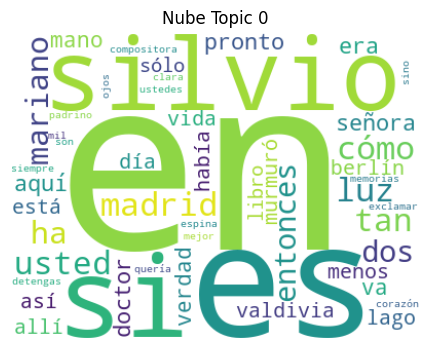

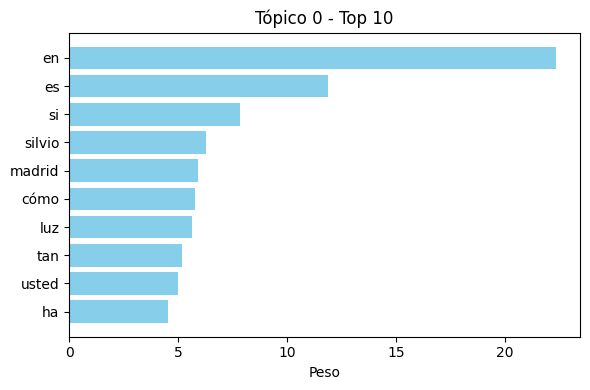

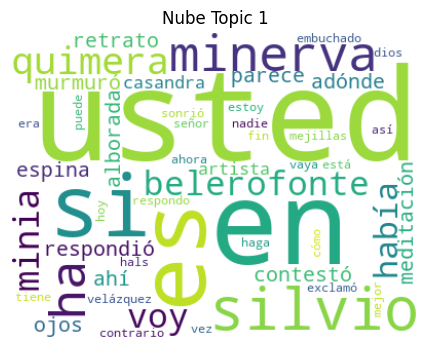

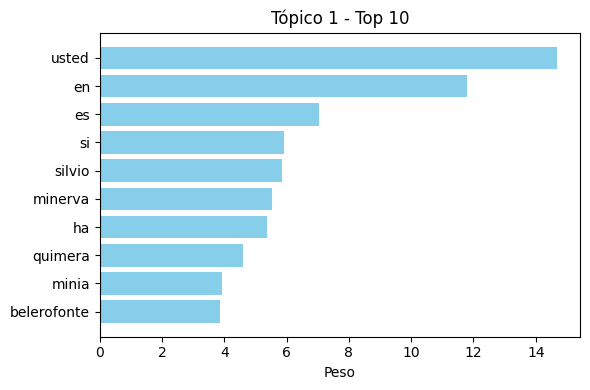

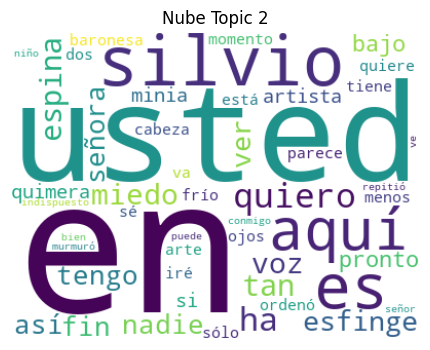

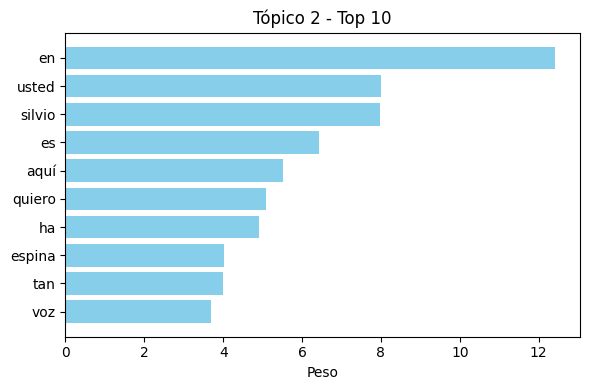

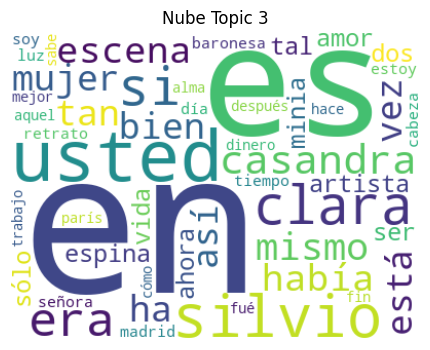

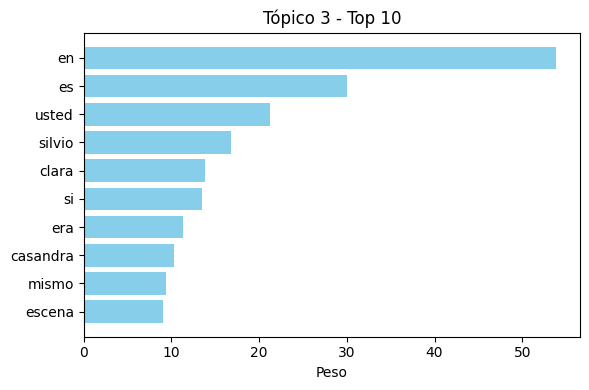

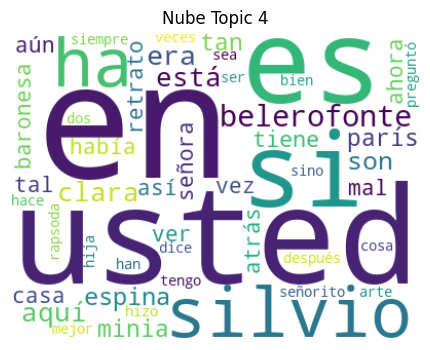

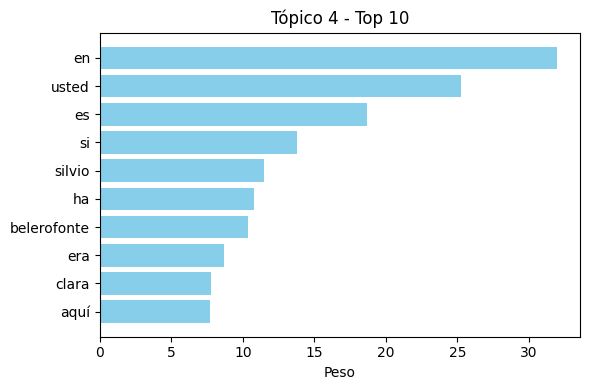

In [158]:
mostrar_topicos_sklearn(lda3, vocab3)
for t in range(lda3.n_components):
    wordcloud_topic(lda3, vocab3, t)
    bar_topic(lda3, vocab3, t)

# Parte 5: Estilo y Comparación entre Autores

- Calcula métricas estilísticas por autor utilizando los párrafos procesados previamente. Para cada autor, estima lo siguiente:

    - **Diversidad léxica:** Proporción entre el número de palabras distintas (vocabulario) y el total de palabras.

    - **Longitud promedio de palabra:** Promedio del número de caracteres por palabra.

    - **Uso relativo de categorías gramaticales:** (Proporción de cada categoría respecto al total de tokens por autor)

        - Sustantivos (`NOUN`)

        - Verbos (`VERB`)

        - Adjetivos (`ADJ`)

- Realiza un gráfico de comparación entre autores: Un radar chart (gráfico tipo telaraña) que compare a los autores en función de estas métricas estilísticas, permitiendo visualizar sus diferencias literarias de manera intuitiva.


In [159]:
autor_1 = "Horacio Quiroga"
autor_2 = "Emilia Pardo Bazán"

df_hq = df1.copy()
df_epb = pd.concat([df2, df3], ignore_index=True)

In [160]:
stopwords = nlp.Defaults.stop_words

def estilo_por_autor(df_autor, nombre):

    texto = "\n".join(df_autor["Texto"].tolist()).lower()
    doc = nlp(texto)
    
    tokens = [
        tok for tok in doc
        if tok.is_alpha and tok.lemma_ not in stopwords and len(tok.lemma_) >= 2
    ]
    total = len(tokens)
    lemmas = [tok.lemma_ for tok in tokens]
    
    diversidad_lex = len(set(lemmas)) / total if total else 0.0
    long_prom_pal = np.mean([len(tok.text) for tok in tokens]) if total else 0.0
    
    n_noun = sum(1 for tok in tokens if tok.pos_ == "NOUN")
    n_verb = sum(1 for tok in tokens if tok.pos_ == "VERB")
    n_adj  = sum(1 for tok in tokens if tok.pos_ == "ADJ")
    
    prop_noun = n_noun / total if total else 0.0
    prop_verb = n_verb / total if total else 0.0
    prop_adj  = n_adj  / total if total else 0.0
    
    return {
        "Autor": nombre,
        "Diversidad léxica": round(diversidad_lex, 3),
        "Long. prom. palabra": round(long_prom_pal, 1),
        "Prop sustantivos": round(prop_noun, 3),
        "Prop verbos": round(prop_verb, 3),
        "Prop adjetivos": round(prop_adj, 3)
    }

In [161]:
stats_hq  = estilo_por_autor(df_hq, autor_1)
stats_epb = estilo_por_autor(df_epb, autor_2)

In [162]:
df_estilo = pd.DataFrame([stats_hq, stats_epb]).set_index("Autor")
df_estilo

Diversidad léxica  Long. prom. palabra  Prop sustantivos  \
Autor                                                                          
Horacio Quiroga                 0.288                  6.8             0.483   
Emilia Pardo Bazán              0.216                  7.1             0.487   

                    Prop verbos  Prop adjetivos  
Autor                                            
Horacio Quiroga           0.274           0.161  
Emilia Pardo Bazán        0.266           0.182

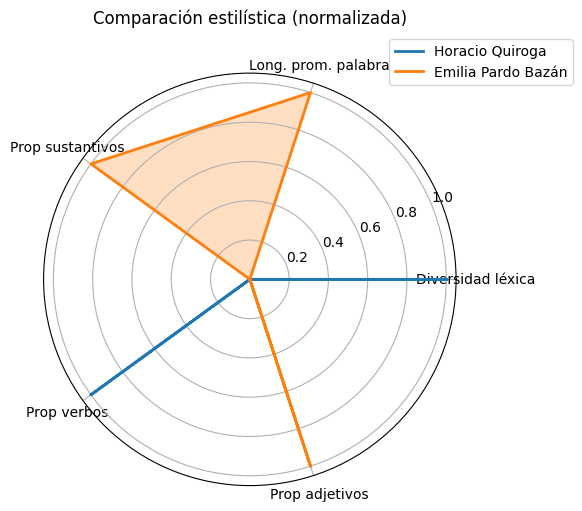

In [163]:
df_norm = (df_estilo - df_estilo.min()) / (df_estilo.max() - df_estilo.min())

labels = df_norm.columns.tolist()
n = len(labels)
angles = np.linspace(0, 2*np.pi, n, endpoint=False).tolist()
angles += angles[:1]

val_hq  = df_norm.loc["Horacio Quiroga"].tolist(); val_hq  += val_hq[:1]
val_epb = df_norm.loc["Emilia Pardo Bazán"].tolist(); val_epb += val_epb[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
ax.plot(angles, val_hq,  label="Horacio Quiroga",  linewidth=2)
ax.fill(angles, val_hq,  alpha=0.25)
ax.plot(angles, val_epb, label="Emilia Pardo Bazán", linewidth=2)
ax.fill(angles, val_epb, alpha=0.25)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Comparación estilística (normalizada)", y=1.1)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

# Parte 6: Reflexión Crítica y Conclusiones

- ¿Qué diferencias semánticas y emocionales observaste entre los cuentos?

- ¿Qué técnicas de NLP te parecieron más útiles para textos literarios?

- ¿Qué limitaciones encontraste (ambigüedad, ironía, metáforas, etc.)?

- ¿Qué podrías explorar en futuras investigaciones similares?

